# Tools for Modern Macroeconometrics: Homework 4

# Jan Suchánek

In [43]:
library(dplyr)
install.packages("pdfetch")
library(pdfetch)
install.packages("tsbox")
library(tsbox)
install.packages("forecast")
library(forecast)
install.packages("dlm")
library(dlm)
if (!require(forecast)) install.packages("forecast")
if (!require(uroot)) install.packages("uroot")
library(stats)
library(repr) 
library(tseries)
library(readr)
library(forecast)
library(uroot)


  There is a binary version available but the source version is later:
        binary source needs_compilation
pdfetch  0.2.4  0.2.6             FALSE



installing the source package 'pdfetch'




  There is a binary version available but the source version is later:
      binary source needs_compilation
tsbox  0.2.1  0.3.1             FALSE



installing the source package 'tsbox'




  There is a binary version available but the source version is later:
         binary source needs_compilation
forecast   8.14   8.16              TRUE

  Binaries will be installed


Warning message:
"package 'forecast' is in use and will not be installed"Warning message:
"package 'dlm' is in use and will not be installed"

As in previous assignment, I will focus on Finland and finnish inflation from 1996 up until now. First, I will download the data and visualize it. Then, I will shift to month-on-month changes, thus I will transform the data and again visualize it in order to gain some general idea about its structure. 

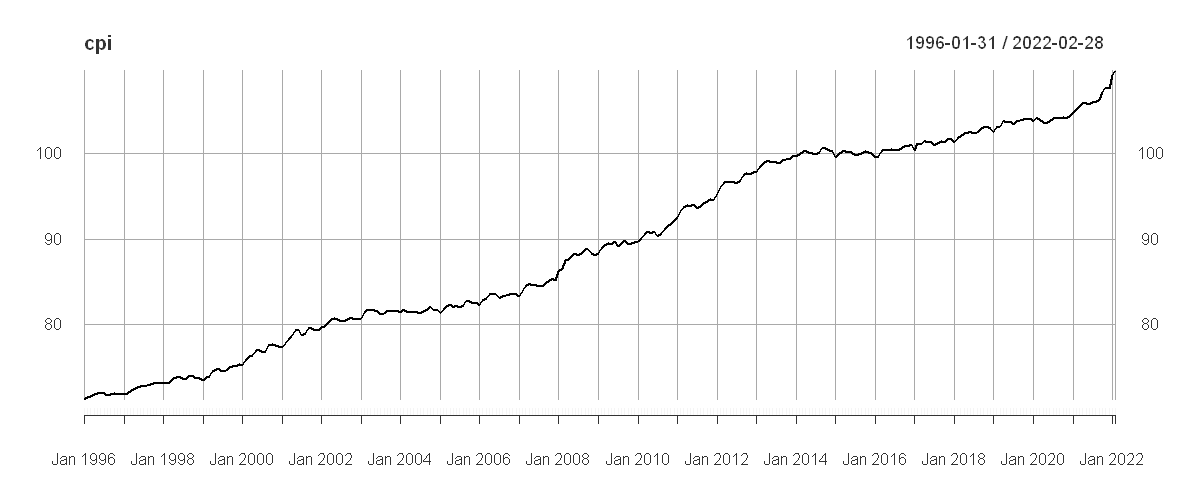

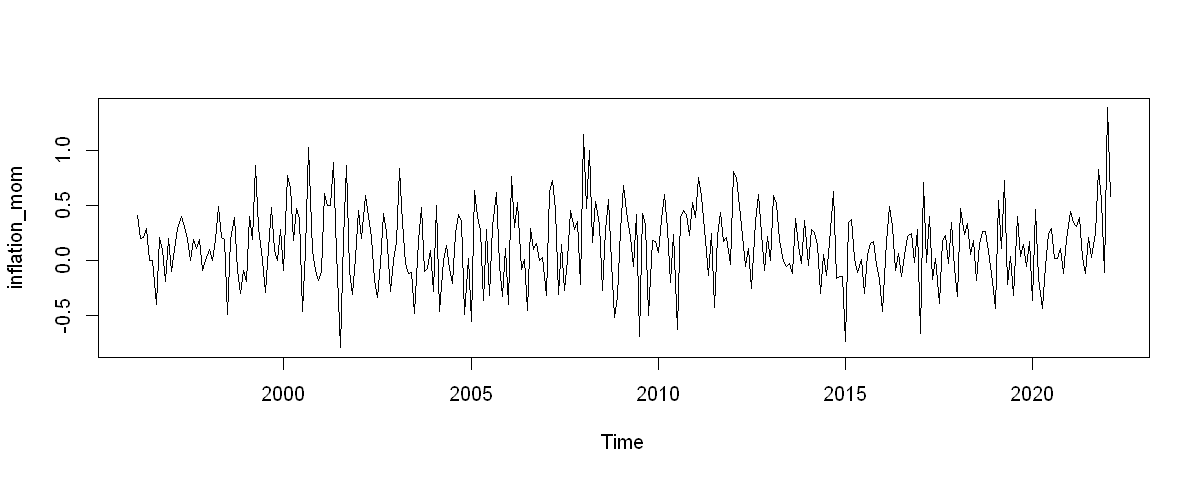

In [44]:
cpi <- pdfetch_EUROSTAT("prc_hicp_midx", FREQ="M", UNIT="I15", COICOP = "CP00", GEO="FI")

options(repr.plot.width = 10, repr.plot.height = 4)

plot(cpi)
x <- ts_first_of_period(cpi) # tsbox requires first day of a period in time stamp
cpi_fi <- ts_ts(x)
inflation_mom <- diff(log(cpi_fi) * 100, lag = 1)



plot.ts(inflation_mom)

On first glance, the data do not seem to be problematic except for latest observation, which makes sense according to what happens globally.

## 1) Estimate the local level model and the basic structural model using StructTS function, and make a forecast for 2 years ahead.

In [45]:
model_level <- StructTS(inflation_mom, type="level")
model_level


Call:
StructTS(x = inflation_mom, type = "level")

Variances:
  level  epsilon  
 0.0000   0.1149  

According to the, there is zero level and quite small volatility. Again, lets visualize:

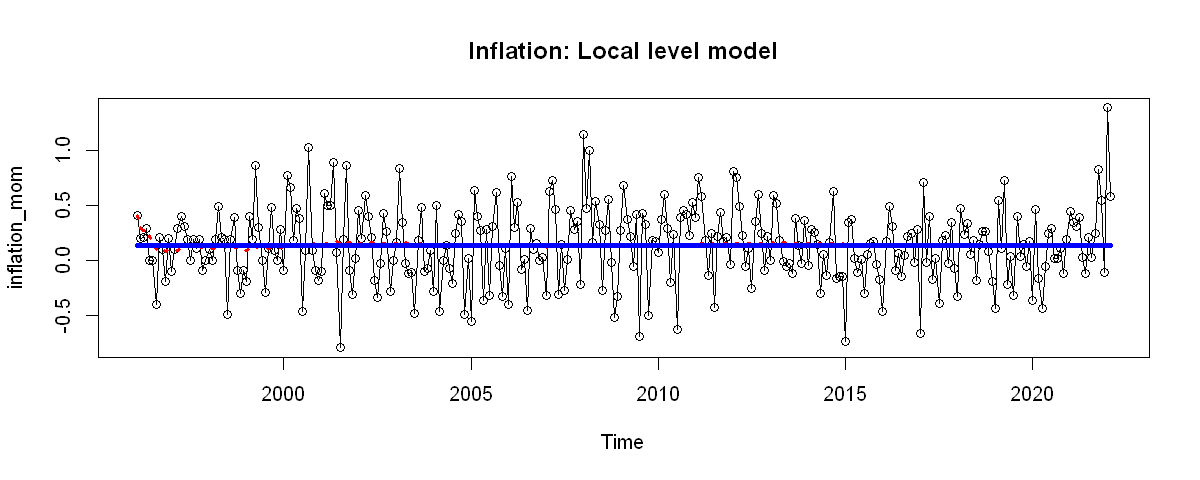


	Shapiro-Wilk normality test

data:  model_level$residuals
W = 0.99551, p-value = 0.5064



	Box-Ljung test

data:  model_level$residuals
X-squared = 130.81, df = 10, p-value < 2.2e-16


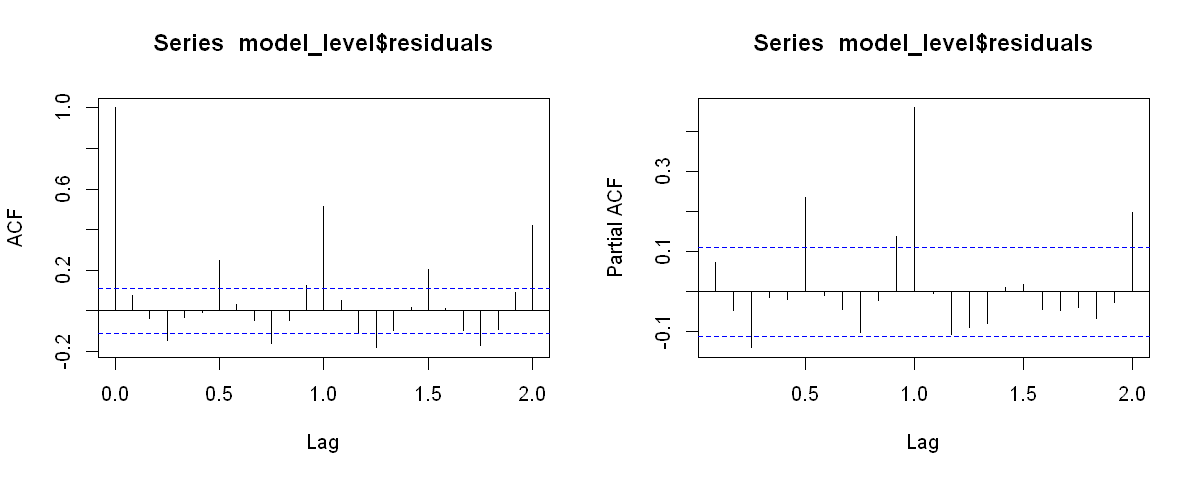

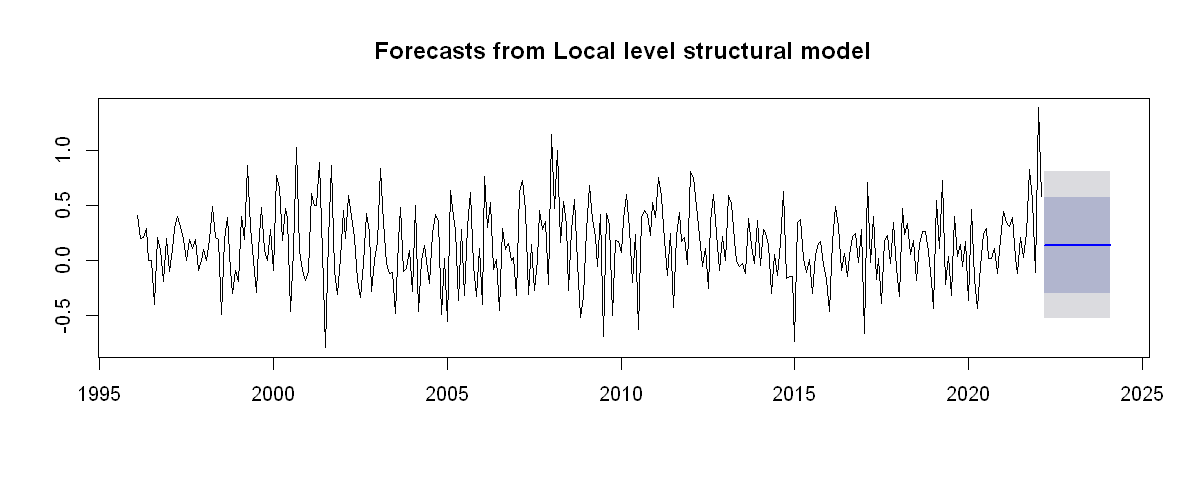

In [46]:
plot(inflation_mom, type = "o", main="Inflation: Local level model")
lines(fitted(model_level), lty = "dotted", lwd = 3, col = "red")     # fitted
lines(tsSmooth(model_level), lwd = 4, col = "blue")                  # smoothed

par(mfrow = c(1, 2))
acf(model_level$residuals)
pacf(model_level$residuals)
shapiro.test(model_level$residuals)
Box.test(model_level$residuals, lag = 12, type = "Ljung", fitdf = 2)

model_level_forecast <- forecast(model_level)
par(mfrow = c(1, 1))
options(repr.plot.width = 10, repr.plot.height = 4)
plot(model_level_forecast)

Considering Local-level model, there is only small difference between smoothed and fitted values. According to ACF, PACF and Box-Ljung test, I believe that seasonality reamins in the model. Nevertheless, it seems to be only drawback of the model. For next two years, the model predicts small constant positive inflation, which is what an economists wants to see.


Call:
StructTS(x = inflation_mom, type = "BSM")

Variances:
    level      slope       seas    epsilon  
1.766e-03  3.385e-07  6.499e-03  4.738e-02  

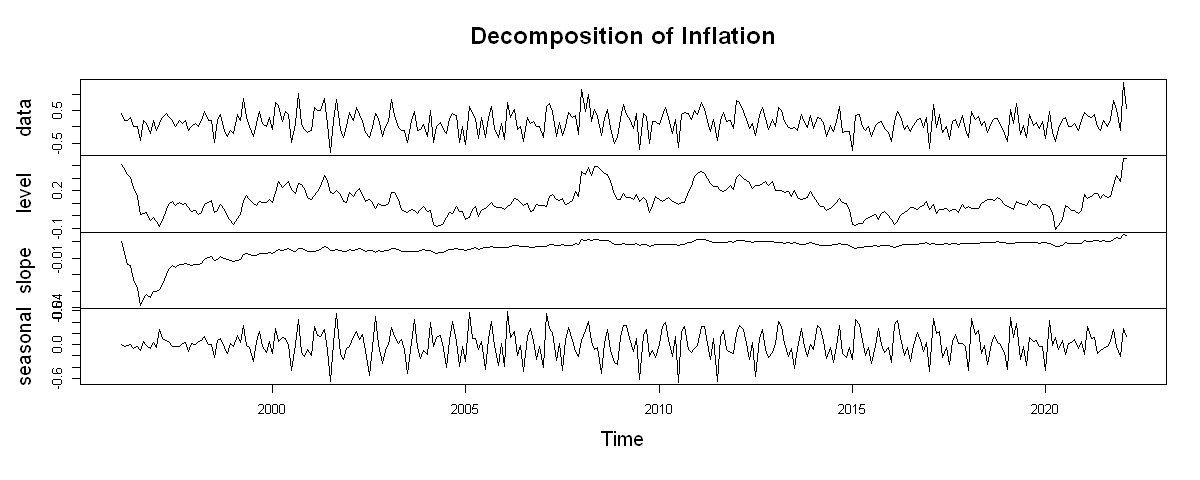

In [47]:
model_bsm <- StructTS(inflation_mom, type="BSM")
model_bsm

model_bsm_decomp <- cbind(inflation_mom,fitted(model_bsm))
colnames(model_bsm_decomp) <- c("data","level","slope", "seasonal")
plot(model_bsm_decomp, main="Decomposition of Inflation")

Basic structural model implies all variances to be quite small, thus there is little volatility and even smaller part of the volatility is explained by seasonality. Taking a look at the decomposition, there seems to be seasonality, however it is consistent throughout time. Now I will check the quality of the model by inspecting the residuals and make forecasts:


	Shapiro-Wilk normality test

data:  model_bsm$residuals
W = 0.97471, p-value = 2.56e-05



	Box-Ljung test

data:  model_bsm$residuals
X-squared = 18.547, df = 10, p-value = 0.04641


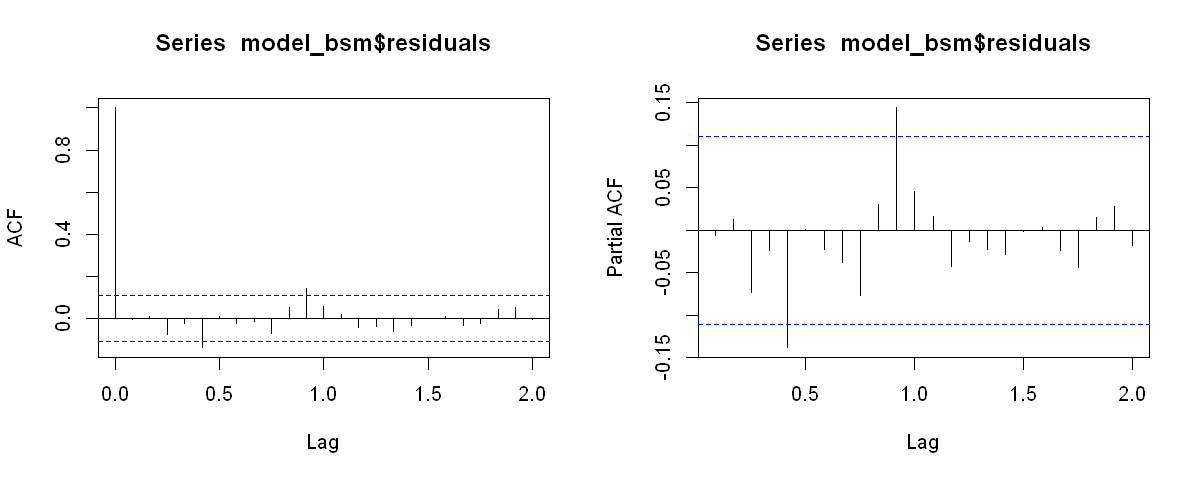

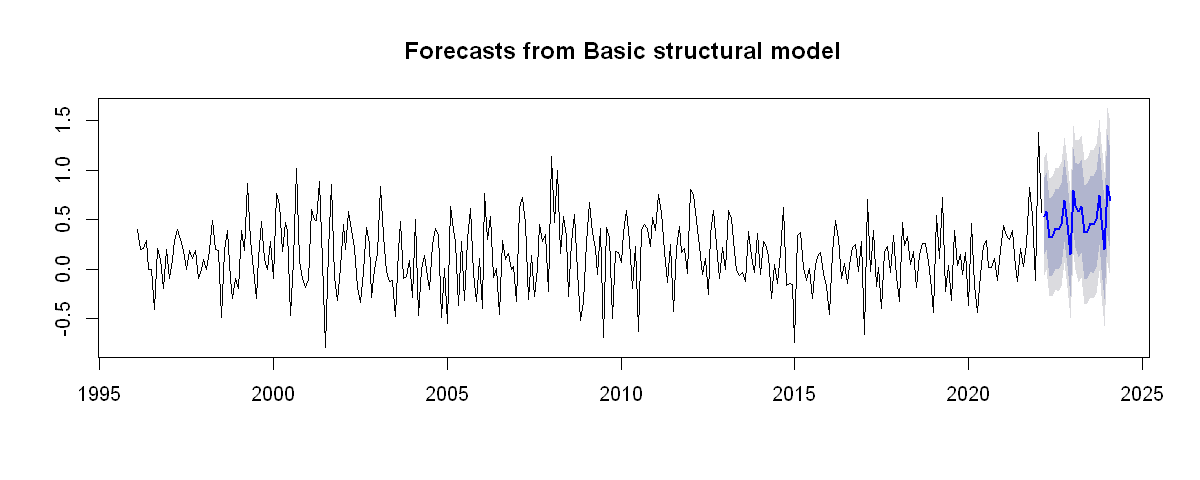

In [48]:
par(mfrow = c(1, 2))
acf(model_bsm$residuals)
pacf(model_bsm$residuals)
shapiro.test(model_bsm$residuals)
Box.test(model_bsm$residuals, lag = 12, type = "Ljung", fitdf = 2)

model_level_forecast <- forecast(model_level)
par(mfrow = c(1, 1))
model_bsm_forecasts <- forecast(model_bsm)
plot(model_bsm_forecasts)

To be honest, I am not really sure what to make of this. ACF and PACF look fine. Some lags look borderline significant, but otherwise no problem. On the other hand, both tests return unsatisfactory results - residuals do not seem to be normally distributed and in addition serial correlation seems to exist in the data. Thus I would conclude that this method might not be appropriate for this data, or at least the data deserve to be transformed some more. Therefore the forecasts might not be as reliable as I would like them to. The prediction is that there will overall be higher rate of growth of inflation. This makes sense, however considering local european situation right now, war in Ukraine will cause upward stochastic shocks in near future, where it is rather difficult to predict their magnitude.

## 2) Redo the exercise with the help of the DLM package or with a Kalman filter code written from scratch. Is the result identical to the previous exercise?



In [49]:
#Local level model

# model specification
dlm_llm <- function(parm) {
  dlmModPoly(order = 1, dV = exp(parm[1]), dW = exp(parm[2]))
}

# Fitting the model: parm - setting initial values, here zeros; build - uses previous object. 
dlm_llm_fit <- dlmMLE(inflation_mom, parm = c(0,0), build = dlm_llm, hessian = TRUE)
(conv <- dlm_llm_fitting$convergence)

[1] 0

Initial values of parameters are set to zero. Next, I will proceed to likelihood function and information criteria for the model.

In [65]:
loglik <- dlmLL(inflation_mom, dlmModPoly(1))
n.coef <- 2
r.aic <- (2 * (loglik)) + 2 * (sum(n.coef))  #dlmLL caculates the neg. LL
r.bic <- (2 * (loglik)) + (log(length(inflation_mom))) * (n.coef)
dlm_llm_mod <- dlm_llm(dlm_llm_fit$par)
obs.error.var <- V(dlm_llm_mod)
state.error.var <- W(dlm_llm_mod)

Next, filtering and smoothing, measurement errors and diagnostic tests.


	Shapiro-Wilk normality test

data:  resids
W = 0.99551, p-value = 0.5064


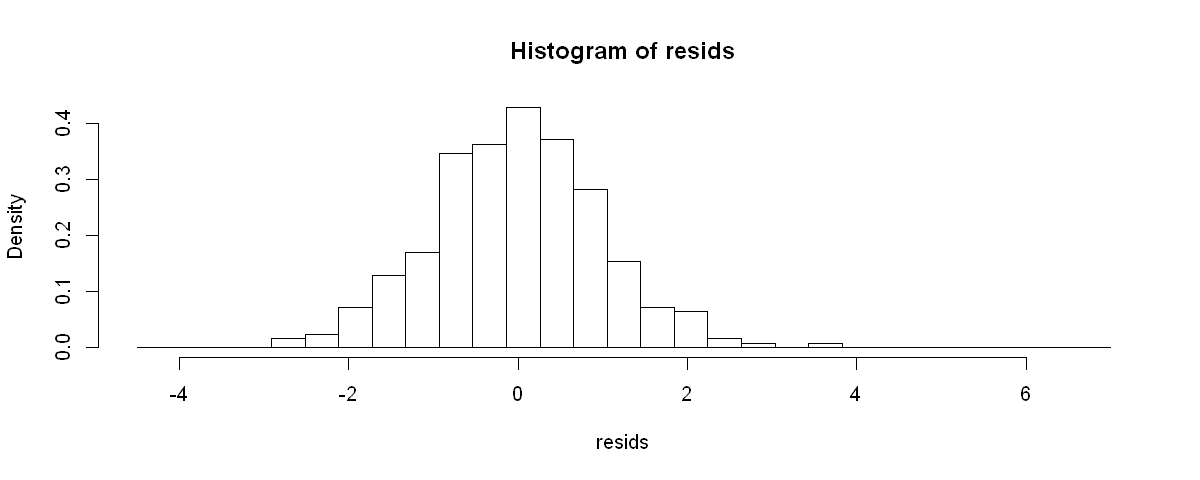


	Box-Ljung test

data:  resids
X-squared = 130.81, df = 12, p-value < 2.2e-16


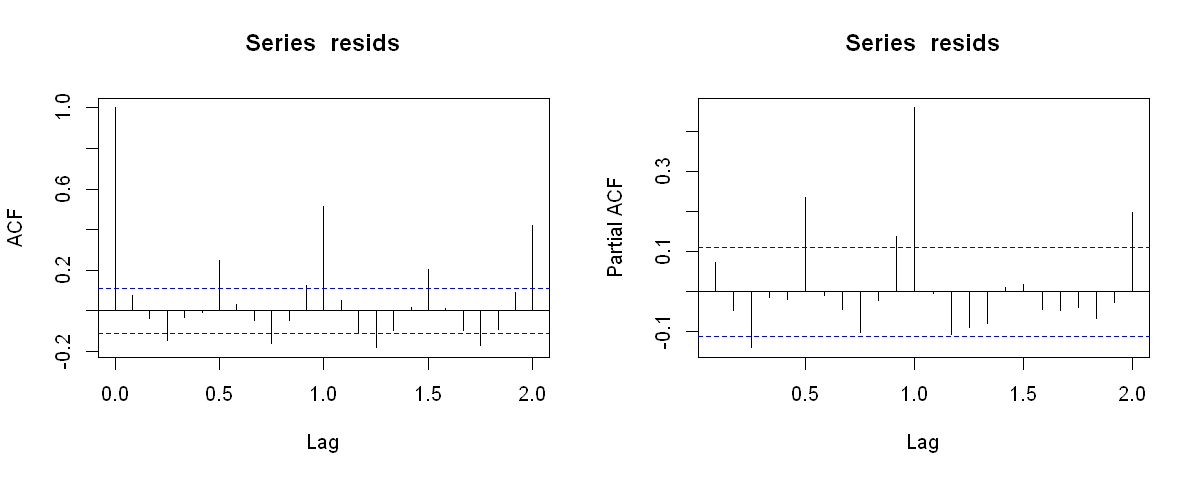

In [51]:
# Filtering and smoothing
dlm_llm_filt <- dlmFilter(inflation_mom, dlm_llm_mod)
dlm_llm_smooth <- dlmSmooth(dlm_llm_filt)

# Get residuals and create time series object from smoothed series 
resids <- residuals(dlm_llm_filt, sd = FALSE)
mu <- dropFirst(dlm_llm_smooth$s)
mu.1 <- mu[1]
mu.end <- mu[length(mu)]

# Diagnostics
shapiro.test(resids)
par(mfrow = c(1,1))
hist(resids, prob = TRUE, breaks = seq(-4.5,7, length.out = 30))
par(mfrow = c(1,2))
acf(resids)
pacf(resids)
Box.test(resids,lag=12,type = "Ljung")

All diagnostics returns same results as in subsection 1, which is expected and therefore I will not repeat my comments on the results. Next, I will compute confidence intervals and forecasts and visualize them.

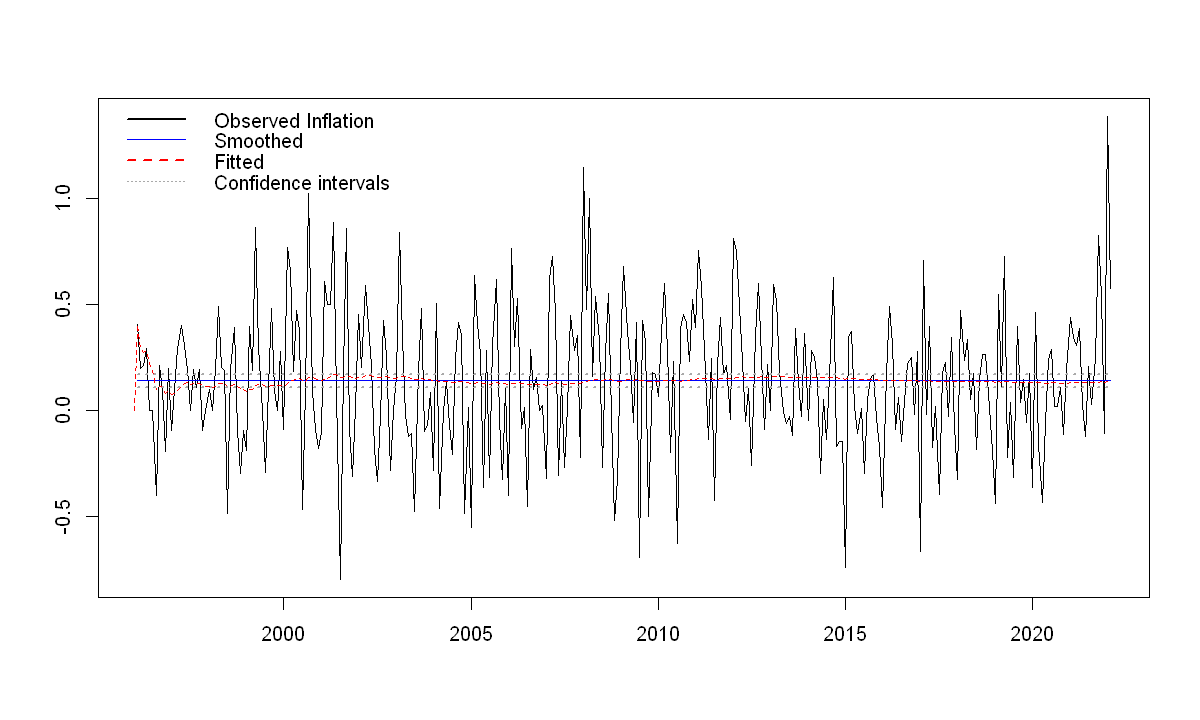

In [57]:
conf.tmp <- unlist(dlmSvd2var(dlm_llm_smooth$U.S, dlm_llm_smooth$D.S))
conf <- ts(as.numeric(conf.tmp)[-1], start = c(1996, 1), 
           frequency = 12)
wid <- qnorm(0.05, lower = FALSE) * sqrt(conf)
conf.pos <- mu + wid
conf.neg <- mu - wid

dlm_llm_forecast <- dlmForecast(dlm_llm_filt, nAhead = 24)
var.2 <- unlist(dlm_llm_forecast$Q)
wid.2 <- qnorm(0.05, lower = FALSE) * sqrt(var.2)
comb.fore <- cbind(dlm_llm_forecast$f, dlm_llm_forecast$f + wid.2, dlm_llm_forecast$f - wid.2)
comb.state <- cbind(mu, conf.pos, conf.neg)
data <- ts(rbind(comb.state, comb.fore), start = c(1996,1), frequency = 12)

options(repr.plot.width = 10, repr.plot.height = 6)

plot.ts(inflation_mom, col = "black", xlab = "", ylab = "", lwd = 1.5)
lines(mu, col = "blue") # smoothed
lines(dlm_llm_filt$m, col = "red", lty = "dashed") #fitted
lines(conf.pos, col = "darkgrey", lty = "dotted", lwd = 2) # conf. interval
lines(conf.neg, col = "darkgrey", lty = "dotted", lwd = 2) # conf. interval
legend("topleft", legend = c("Observed Inflation", "Smoothed","Fitted", "Confidence intervals"), 
    lwd = c(2, 1), col = c("black", "blue", "red", "darkgrey"), bty = "n", lty = c("solid", "solid", "dashed", "dotted"))

To sum up, using dlm package does not make a difference - model seems to be completely identical to the one created using StructTS.

# 3) Make ARIMA prediction as well, and compare the prediction with the prediction from the Kalman filter model.

First, lets check the stationarity. In order to be consistent, I will then again visualize ACF and PACF.

Warning message in adf.test(inflace):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  inflace
Dickey-Fuller = -5.3391, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


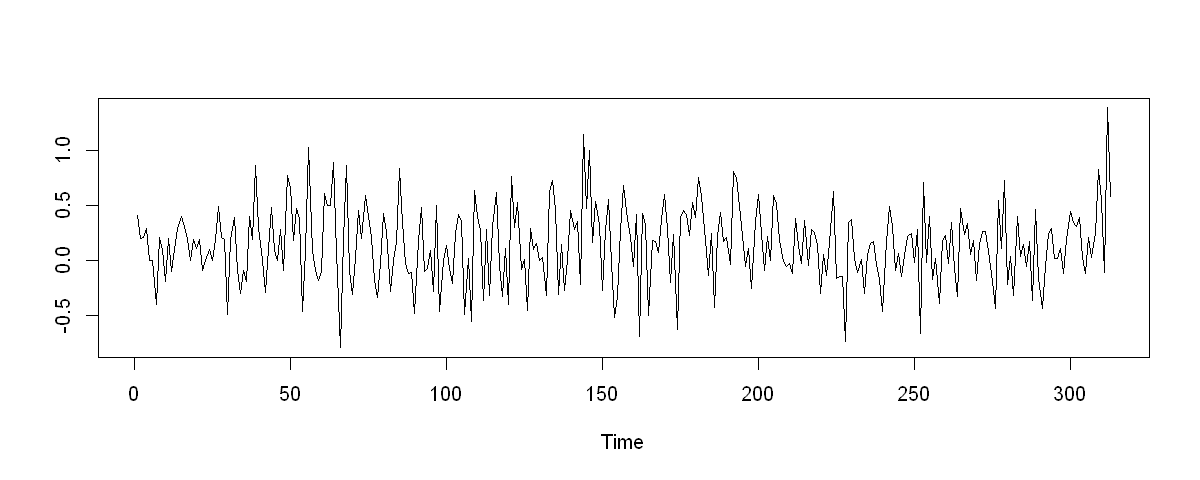

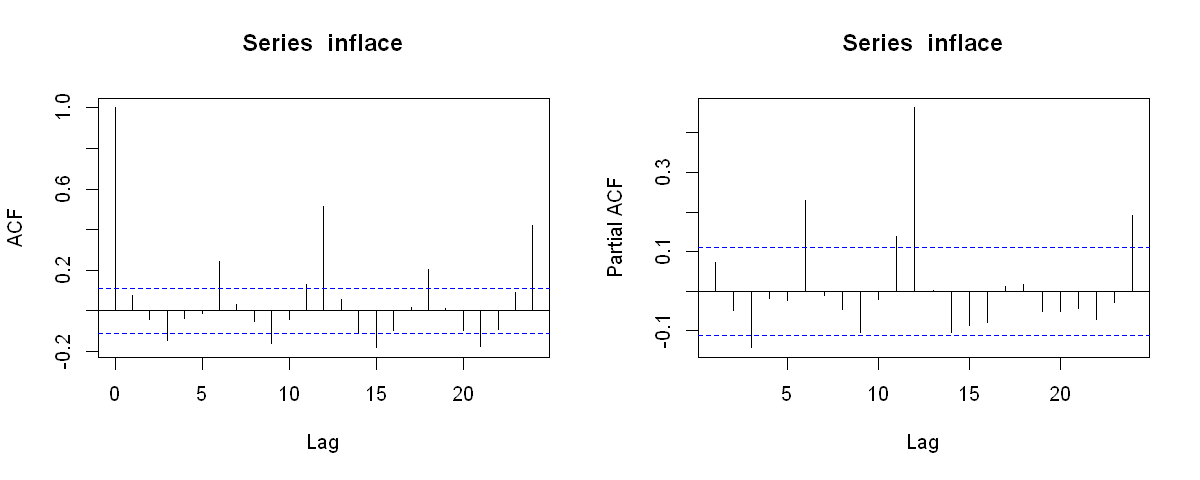

In [63]:
inflace <- as.vector(inflation_mom)

adf.test(inflace)

options(repr.plot.width = 10, repr.plot.height = 4)
plot.ts(inflace, ylab = NA)

par(mfrow = c(1, 2))
acf(inflace)
pacf(inflace)

The data are stationary, however there seems to be strong seasonality. From ACF and PACF is not obvious which kind of model should I choose (or use as benchmark), thus I will use auto.arima function to handle this for me.

Series: inflace 
ARIMA(3,0,2) with non-zero mean 

Coefficients:
          ar1     ar2      ar3     ma1      ma2    mean
      -0.4184  0.3307  -0.1933  0.5177  -0.3602  0.1372
s.e.   0.2100  0.1938   0.0597  0.2094   0.1995  0.0169

sigma^2 estimated as 0.1106:  log likelihood=-96.69
AIC=207.38   AICc=207.75   BIC=233.61

Training set error measures:
                       ME      RMSE       MAE  MPE MAPE      MASE         ACF1
Training set 0.0001359979 0.3293999 0.2530247 -Inf  Inf 0.6888196 -0.003621772


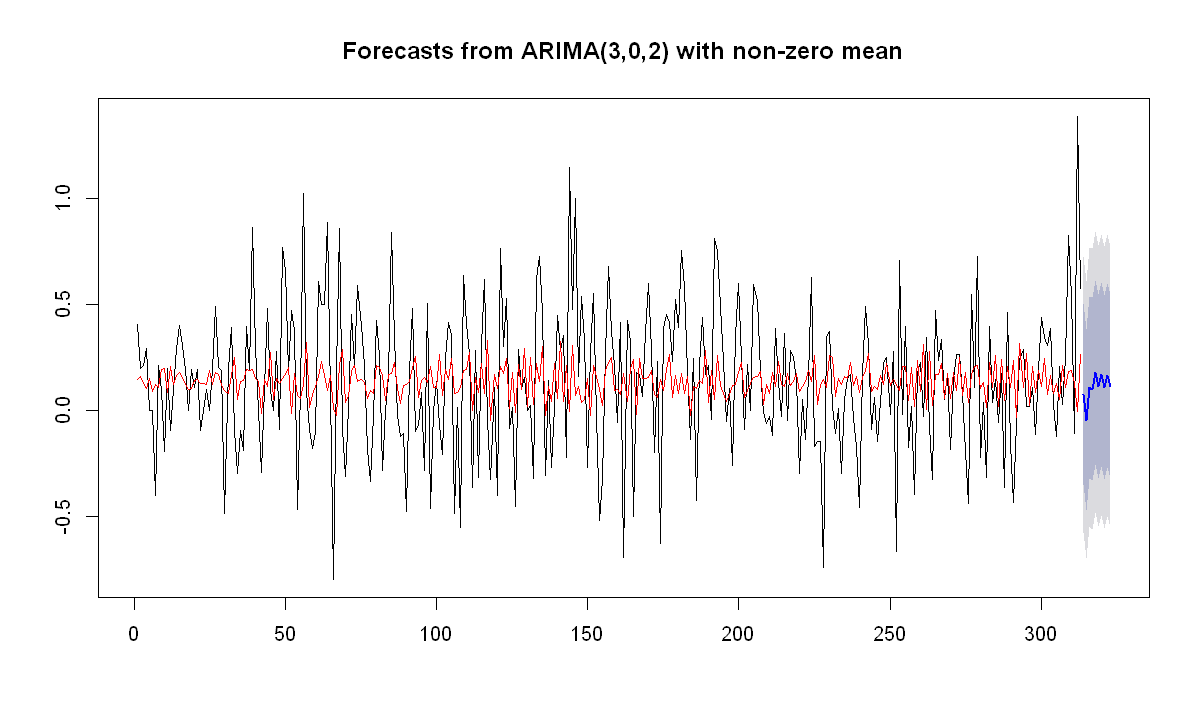

In [62]:
model_auto <- auto.arima(inflace, approximation = FALSE, stepwise = FALSE)
summary(model_auto)

model_auto_forecast <- forecast(model_auto)
plot(model_auto_forecast)
lines(model_auto$fitted, col = "red")

It seems that it is not ideal to handle the data using arima, which I believe is the point of this exercise. 